# Import

In [133]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from summarytools import dfSummary

from sklearn.preprocessing import StandardScaler

import optuna
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [134]:
# 시각화시 한글 깨짐 방지
import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')  # Linux 사용자의 경우
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# Data Load

In [135]:
train_df = pd.read_csv('./datasets/train.csv').drop(columns=['ID'])
test_df = pd.read_csv('./datasets/test.csv').drop(columns=['ID'])

# EDA & Preprocessing

## Categorical

### categorical_columns

In [136]:
categorical_columns = [
    "시술 시기 코드",
    "시술 당시 나이",
    "시술 유형",
    "특정 시술 유형",
    "배란 자극 여부",
    "배란 유도 유형",
    "단일 배아 이식 여부",
    "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부",
    "남성 주 불임 원인",
    "남성 부 불임 원인",
    "여성 주 불임 원인",
    "여성 부 불임 원인",
    "부부 주 불임 원인",
    "부부 부 불임 원인",
    "불명확 불임 원인",
    "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인",
    "불임 원인 - 배란 장애",
    "불임 원인 - 여성 요인",
    "불임 원인 - 자궁경부 문제",
    "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도",
    "불임 원인 - 정자 면역학적 요인",
    "불임 원인 - 정자 운동성",
    "불임 원인 - 정자 형태",
    "배아 생성 주요 이유",
    "총 시술 횟수",
    "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수",
    "DI 시술 횟수",
    "총 임신 횟수",
    "IVF 임신 횟수",
    "DI 임신 횟수",
    "총 출산 횟수",
    "IVF 출산 횟수",
    "DI 출산 횟수",
    "난자 출처",
    "정자 출처",
    "난자 기증자 나이",
    "정자 기증자 나이",
    "동결 배아 사용 여부",
    "신선 배아 사용 여부",
    "기증 배아 사용 여부",
    "대리모 여부",
    "PGD 시술 여부",
    "PGS 시술 여부"
]

### Summary
- "알 수 없음"과 nan 처리 필요

In [137]:
dfSummary(train_df[categorical_columns])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,시술 시기 코드[object],1. TRDQAZ2. TRCMWS3. TRYBLT4. TRVNRY5. TRJXFG6. TRZKPL7. TRXQMD,"38,969 (15.2%)38,090 (14.9%)36,713 (14.3%)36,173 (14.1%)36,031 (14.1%)35,544 (13.9%)34,831 (13.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACo0lEQVR4nO3bQUojUQBF0Z8mSDtJCAEX4yJ6sb2I7EYkNWjFSXrQIBrjzH+b4DkLqGRwqaKK/1an02lA4cf//gN8H2IjIzYyYiMjNjKrMcbtGONm4m+8nE6np4nX50qs9/v9r81ms5v1A8uyPK5Wq9+CY73ZbHb39/dP2+32+asvfjwefx4Oh93Dw8PNGENs39x6jDG22+3z3d3dn0m/cTvpulwZLwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxk1mP8Owo04+Kzrst1Wi/L8ng4HHZj0lGgZVkexxgvM67NdXEsnMzKIp7K7Dubuxqvpg5ejF14a9rgxdiFc7MHL8YuvPJRl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyExbV1lWcW7qusqyirdsEMhYV5GZeWdzV+OdaesqyyrOTVlXWVZxycx1lWUV7/ioS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERmbK4MXYhUumDV6MXTjnWDgZgxcyXhDIeIySsa4iY11FxrqKjBcEMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MtZVZKyryDgWTsa6iow7GxmDFzIGL2QMXsj4qEtGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbG4IWMwQsZx8LJGLyQ8YJAZtZj1COUD6asqyyruOTL11WWVXxm1rrKsooPvCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGR+fJ1lWUVn5myrrKs4hLHwslYV5FxZyNj8ELG4IWMwQsZH3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MdRUZ6yoyNghkrKvIeEEgIzYyYiMjNjJ/AVBveRWtjjpOAAAAAElFTkSuQmCC"">",0(0.0%)
2,시술 당시 나이[object],1. 만18-34세2. 만35-37세3. 만38-39세4. 만40-42세5. 만43-44세6. 만45-50세7. 알 수 없음,"102,476 (40.0%)57,780 (22.5%)39,247 (15.3%)37,348 (14.6%)12,253 (4.8%)6,918 (2.7%)329 (0.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC+ElEQVR4nO3bzW3bWABG0UdDyEw2EgwDLmGmBxeRYlOEikgPhmEukkw2mkWQwPnfiJeEdE4FT8AFiSfwm06n04DCzdoH4HqIjYzYyIiNjNjITGOM12OMV2sfZAWfTqfTh7UPcU12d3d3b/b7/e3aB6nN8/w0TdNbwXV2+/3+9uHh4cPhcPi49mEqz8/Pfx+Px9vHx8dXYwyxRXZjjHE4HD7e39+/X/swsddrH+DauCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGR2Y3x+ZObtQ9SurbfuxW7eZ6fjsfj7biyT27meX4aY3xa+xzXxGfhZCaLeCpbe7J52lywTQ1ejFAu22YGL0Yol29rg5eruhFfG3/qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmc2sq7ZwBpa1qXWVxdNls0EgY11FpniyeVoxxgjWVRZTfLHouspiipeKddXqt1y2wZ+6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZBYdvBix8NLigxcjFr7wWTgZgxcyLghkln6NeoXy1aLrKssqXlpsXWVZxfeWXldZVvGVCwIZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZxdZVllV8b9F1lWUVL/ksnIx1FZk/Pdk8mTib3w5eDFY4p18OXgxWOLc/DV4MVjgbf+qSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGR+eXgxWCFc/vt4MVghXPyWTgZgxcyLghkfvYa9epkET+sqyyqWMo36yqLKpb0s3WVRRWLcEEgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIj8826yqKKJf2wrrKoYik+CydjXUXGBYHMzTRN/07T5GLA4m7GGP+MMf5a+yBcPq9RMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNzM8Z4N8b4b+2DcPkMXsh4jZIRGxmxkREbGbGR+R92akkFhFbkuQAAAABJRU5ErkJggg=="">",0(0.0%)
3,시술 유형[object],1. IVF2. DI,"250,060 (97.5%)6,291 (2.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOElEQVR4nO3bMYqDQBiG4X8WCZtmBhE8jIfYw+4h5jYiTrEJaWaLIKzGLvoNzL5PZ/cXL0KCn8s5G6DgzOxqZpfSh6BKj5zzbXlouq778t63JS9CnVJKk3Puewmu8d63wzDcQgj30sehHvM8f8YY23EcL2b2jM3MLIRw7/v+p+h1qNH178NHqSvw/xAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CDTmD0/dCt9COqy11STUppijK1tPnQD3pVSmszssTwzeMGZVoMXx5QPKntvtlWNwFFepnzb+RVwlNWUb29+BRxlb8rHr1Kcgj91IUNskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoPMasrHpA9nepnybedXwFEYvEDmFwpbat8xTAwqAAAAAElFTkSuQmCC"">",0(0.0%)
4,특정 시술 유형[object],1. ICSI2. IVF3. Unknown4. IUI5. ICSI:ICSI6. ICSI / BLASTOCYST 7. IVF / BLASTOCYST8. IVF:IVF9. ICSI:IVF10. ICSI / AH11. other,"122,368 (47.7%)91,755 (35.8%)26,939 (10.5%)6,100 (2.4%)2,314 (0.9%)1,609 (0.6%)1,248 (0.5%)1,146 (0.4%)873 (0.3%)769 (0.3%)1,230 (0.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGl

### nan 포함 칼럼들
- 특정 시술 유형 → "Unknown"
- 단일 배아 이식 여부 → 0
- 착상 전 유전 검사 사용 여부 → 0
- 착상 전 유전 진단 사용 여부 → 0
- 배아 생성 주요 이유 → “현재 시술용”
- 동결 배아 사용 여부 → 0
- 신선 배아 사용 여부 → 1
- 기증 배아 사용 여부 → 0
- 대리모 여부 → 0
- PGD 시술 여부, PGS 시술 여부 → 0

In [138]:
including_na_columns = [
    "특정 시술 유형",
    "단일 배아 이식 여부",
    "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부",
    "배아 생성 주요 이유",
    "동결 배아 사용 여부",
    "신선 배아 사용 여부",
    "기증 배아 사용 여부",
    "대리모 여부",
    "PGD 시술 여부",
    "PGS 시술 여부"
]

In [139]:
dfSummary(train_df[including_na_columns])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,특정 시술 유형[object],1. ICSI2. IVF3. Unknown4. IUI5. ICSI:ICSI6. ICSI / BLASTOCYST 7. IVF / BLASTOCYST8. IVF:IVF9. ICSI:IVF10. ICSI / AH11. other,"122,368 (47.7%)91,755 (35.8%)26,939 (10.5%)6,100 (2.4%)2,314 (0.9%)1,609 (0.6%)1,248 (0.5%)1,146 (0.4%)873 (0.3%)769 (0.3%)1,230 (0.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD9ElEQVR4nO3dQW4TZwCG4X8ii8LGlmUpR2jvkENw2B7Ch+AOURQvCmXjLkoXCFQFnHnHHp7nBD/Rq/F4NB+ezufzgMLd0gfg1yE2MmIjIzYyYiMjNjJiIyM2MmIjM40x3o0x3ix9kBvw+Xw+f1z6ELdsczgc3m+32/3SB7l2p9PpaZqmPwX38zbb7Xb/8PDwcbfbfVr6MNfq+fn57fF43D8+Pr4ZY4jtJ23GGGO32326v7//a+nDXLl3Sx/g1vmCQEZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDZj/Pu+1tIHuWb+Pq9jczqdno7H4354X+t/nU6npzHG56XPcctsEF7OBuFCk/8yi8rar2yuRldk1esqi6jrstp1lUXU9Vn7uso37CvioS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZ1Q5e1vhvunWrHrwYqVwXr4WTMXgh8xpXNlcPXuTiwYtRCS910eDFqIQf8RqDl9V9i2UeHuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRuWjwYlTCj7h48GJUwkt5LZyMwQsZXxDIfO9j1Mcis/hmXWUtxVy+WldZSzGn762rrKWYhS8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZL5aV1lLMadv1lXWUszFa+FkrKvI/HdlG65mzG1zOBzejzGGkQtzu9tut/sv66q1/gwkV8JzNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MpsvA5cxjFyYmdfCyRi8kHFlI2PwQsbghYxHH2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjA0CGesqMq5sZKyryFhXkfHog4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjMELGa+FkzF4IePKRsbghYzBCxmPPsiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kPFaOBmDFzLu2cj4GCVjXUXGuoqMezYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLWVWS8Fk7GuoqMezYyd9M0/TFN09ulD8L63Y0xfh9j/Lb0QVg/H6NkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTuxhgfxhh/L30Q1s8GgYyPUTKmfGT8wgsZv/BCxj0bGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZv/BCxmvhZKyryLhnIyM2MmIjIzYyYiMjNjJiIyM2MmIj8w9v0F+PTpzDHwAAAABJRU5ErkJggg=="">",2(0.0%)
2,단일 배아 이식 여부[float64],1. 0.02. 1.03. nan,"191,677 (74.8%)58,383 (22.8%)6,291 (2.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnklEQVR4nO3bQWricBjG4S+DlHaTIIKH8RBz2DlEbiNiFtPSTWbRVakDhZg3f+zznOADfyoR326e54KEX1sfwM/RVdVLVT1tfQh38z7P8+vWR9yyOxwOv/u+3299CPcxTdOl67o/LQa36/t+fzqdXodheNv6GJa5Xq/P4zjuz+fzU1W1F1tV1TAMb8fj8e/Wx3AXL1sf8D8eEIgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERs6v6+B/U1oewXOuv426apss4jvtq+H9QfN80TZeqet/6jltsEB5PsxuEzpSPlNY+2Zp9V7JcU+uqlpdBLNfMuqr1ZRDLtbau8kT8wPyoS4zYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI2YZtZVLdzAuppaV7W8DGI5GwRirKuI8YBAzK2vUV9lrOLLlM+cjrV8mvKZ07GmW1O+zX8C4TF5QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGzKcpnzkda/oy5TOnYy02CMSY8hHzD0q8o0oh35eYAAAAAElFTkSuQmCC"">","6,291(2.5%)"
3,착상 전 유전 검사 사용 여부[float64],1. nan2. 1.0,"253,633 (98.9%)2,718 (1.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABRElEQVR4nO3bwW2DQBhE4QEhJ1wWIUsuwwW4iBSbIiiAPhBiD1mHy+YQ23IB8ay0eV8Fc3hCCPE3OWcBDo2kXtKh9BBUbc85p+54PH6EEMbSa1CvGOPaNM1nF0IYL5dLGobhWnoU6rNt2/s0TeOyLIdOkoZhuJ5Op6/Sw1CtXpLa0ivwfxAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GDTSb8/uJUegjo9t9XFGNdpmkbdfnAD/lqMcZW0c/AChz3nnBpO+eDy/GTbc86p8B5U7HHKdz+3Iji8ShtCGM/ns263o7y74WVaSer7/rv0ENSPj7qwITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2yIDTbEBhtigw2xwaaVpJTSW+khqF8bY1zneX6cW5UehHpx8AKbHxqqVtmKubAMAAAAAElFTkSuQmCC"">","253,633(98.9%)"
4,착상 전 유전 진단 사용 여부[float64],1. 0.02. nan3. 1.0,"246,864 (96.3%)6,291 (2.5%)3,196 (1.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABrklEQVR4nO3cQWrCQACF4ZcQbLOZEASP4QE8RA/bQ+QA3kOCs2ism3RRKVWjUELewPT/llnN4kcZybMYx1GAQ5n6APg/Ckm1pFXqgyAr53Ech9uH1Xq9

In [140]:
fill_0_columns = ["단일 배아 이식 여부", "착상 전 유전 검사 사용 여부", "착상 전 유전 진단 사용 여부", "동결 배아 사용 여부", 
                  "기증 배아 사용 여부", "대리모 여부", "PGD 시술 여부", "PGS 시술 여부"]

train_df[fill_0_columns] = train_df[fill_0_columns].fillna(0)
train_df["특정 시술 유형"] = train_df["특정 시술 유형"].fillna("Unknown")
train_df["배아 생성 주요 이유"] = train_df["배아 생성 주요 이유"].fillna("현재 시술용")
train_df["신선 배아 사용 여부"] = train_df["신선 배아 사용 여부"].fillna(1)


test_df[fill_0_columns] = test_df[fill_0_columns].fillna(0)
test_df["특정 시술 유형"] = test_df["특정 시술 유형"].fillna("Unknown")
test_df["배아 생성 주요 이유"] = test_df["배아 생성 주요 이유"].fillna("현재 시술용")
test_df["신선 배아 사용 여부"] = test_df["신선 배아 사용 여부"].fillna(1)

# categorical columns의 na 개수 확인
print(train_df[categorical_columns].isna().any().sum())
print(test_df[categorical_columns].isna().any().sum())

0
0


### 알 수 없음 포함 칼럼 (na 처리 후 최빈값으로?)
- 시술 당시 나이 → “만18-34세”
- 배란 유도 유형 → 알 수 없음과 기록되지 않은... 이 대부분이므로 변수 삭제
- 난자 출처 → “본인 제공”
- 난자 기증자 나이 → “알 수 없음”이 제일 빈도가 높음 (변수 제거 고려)
    - 알 수 없음 더미 변수 생성
- 정자 기증자 나이 → “알 수 없음”이 제일 빈도가 높음(변수 제거 고려)
    - 알 수 없음 더미 변수 생성

In [141]:
including_unknown_columns = [
    "시술 당시 나이",
    "배란 유도 유형",
    "난자 출처",
    "난자 기증자 나이",
    "정자 기증자 나이"
]
display((train_df[including_unknown_columns] == "알 수 없음").sum())

시술 당시 나이        329
배란 유도 유형      61917
난자 출처          6291
난자 기증자 나이    242381
정자 기증자 나이    230518
dtype: int64

In [142]:
dfSummary(train_df[including_unknown_columns])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,시술 당시 나이[object],1. 만18-34세2. 만35-37세3. 만38-39세4. 만40-42세5. 만43-44세6. 만45-50세7. 알 수 없음,"102,476 (40.0%)57,780 (22.5%)39,247 (15.3%)37,348 (14.6%)12,253 (4.8%)6,918 (2.7%)329 (0.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC+ElEQVR4nO3bzW3bWABG0UdDyEw2EgwDLmGmBxeRYlOEikgPhmEukkw2mkWQwPnfiJeEdE4FT8AFiSfwm06n04DCzdoH4HqIjYzYyIiNjNjITGOM12OMV2sfZAWfTqfTh7UPcU12d3d3b/b7/e3aB6nN8/w0TdNbwXV2+/3+9uHh4cPhcPi49mEqz8/Pfx+Px9vHx8dXYwyxRXZjjHE4HD7e39+/X/swsddrH+DauCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGR2Y3x+ZObtQ9SurbfuxW7eZ6fjsfj7biyT27meX4aY3xa+xzXxGfhZCaLeCpbe7J52lywTQ1ejFAu22YGL0Yol29rg5eruhFfG3/qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmc2sq7ZwBpa1qXWVxdNls0EgY11FpniyeVoxxgjWVRZTfLHouspiipeKddXqt1y2wZ+6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZBYdvBix8NLigxcjFr7wWTgZgxcyLghkln6NeoXy1aLrKssqXlpsXWVZxfeWXldZVvGVCwIZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZxdZVllV8b9F1lWUVL/ksnIx1FZk/Pdk8mTib3w5eDFY4p18OXgxWOLc/DV4MVjgbf+qSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGR+eXgxWCFc/vt4MVghXPyWTgZgxcyLghkfvYa9epkET+sqyyqWMo36yqLKpb0s3WVRRWLcEEgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIj8826yqKKJf2wrrKoYik+CydjXUXGBYHMzTRN/07T5GLA4m7GGP+MMf5a+yBcPq9RMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNzM8Z4N8b4b+2DcPkMXsh4jZIRGxmxkREbGbGR+R92akkFhFbkuQAAAABJRU5ErkJggg=="">",0(0.0%)
2,배란 유도 유형[object],1. 기록되지 않은 시행2. 알 수 없음3. 세트로타이드 (억제제)4. 생식선 자극 호르몬,"194,432 (75.8%)61,917 (24.2%)1 (0.0%)1 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB4ElEQVR4nO3bwYnbQBTH4TfGbLIXCWNwCUkPLiLFpggVkR6MsQ7ZzV6Uw16WHGPlr8H5vgoe+AfjEfPasiwFCbutB+D/ITZiWlU9V9XT1oOwurdlWV62HuKj/fF4/DYMw2HrQVjXPM/X1tr3noLbD8NwOJ/PL+M4vm49DOu43W6fp2k6XC6Xp6rqJ7aqqnEcX0+n08+th2FVz1sP8CcXBGLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjZl/1/iRl60FYT6+/536e5+s0TYfq8EkKf2+e52tVvW09x0eehT+u7p6FN6t8pLggENPrMdrdEcD9utyu6nEziPt1t13V62YQ9+t1u8pnmAfkgkCM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNmO5W+XqahXV1ucrX4xoa97ODQIxVPmJcEIjZtda+ttb8Keef21XVl6r6tPUgPD7HKDFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IjZVdWPqvq19SA8PgsvxDhGiREbMbariLFdRYxjlBixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMTYriLGdhUxjlFixEbMbyUHeJkuOGXXAAAAAElFTkSuQmCC"">",0(0.0%)
3,난자 출처[object],1. 본인 제공2. 기증 제공3. 알 수 없음,"234,291 (91.4%)15,769 (6.2%)6,291 (2.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABl0lEQVR4nO3bQUrzUBiG0S8/RXSSUApdTBfhYv9FZDelNAMVJ3HgpKKDJJq3WM+ZB+7goeGWvM04jgUJ/659AP6Opqoequru2gfh13kdx/F5zgOb3W732Lbtdq0TcZuGYTg1TfN/TnCbtm23h8Phueu6lzUPx+04n8/3fd9vj8fjXVVNj62qquu6l/1+/7Ta6bhFD3MfcEEgRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERsym6v37pGsfhN9jaS+bYRhOfd9va8H3SfxdwzCcqup1zjM2CCw1e4PQmPKRMueXbXbJcGnyumrJmgYuTVpXLV3TwKU56yq3Vb7Fn7rEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiJm0rrK+4idMXlctWdPAJRsEYqyriHFBIOar16jXJav4NOUz2WMtH6Z8Jnus6aspn8keq3BBIEZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEbMhymfyR5r+jTlM9ljLTYIxJjyEfMGvvGjSo7zztsAAAAASUVORK5CYII="">",0(0.0%)
4,난자 기증자 나이[object],1. 알 수 없음2. 만31-35세3. 만26-30세4. 만21-25세5. 만20세 이하,"242,381 (94.6%)6,366 (2.5%)4,976 (1.9%)2,334 (0.9%)294 (0.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACVUlEQVR4nO3dTW7aYBiF0dfISpuJEUJiCe0eWEQW20WwiO4BITwoaSZ0UFKVhp8I1RfVPWcWMfkGjzBGvqTZ7/cFCZN7H4D/h9iIERsxTVU9VtXDvQ/CKLzs9/vduRfb+Xz+1HXdLHkixqnv+03TNF/OBdd2XTdbLpe76XT6nD4c47Hdbj+uVqvZer1+qKrTsVVVTafT58Vi8S16Osbo8dKLbhCIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjZi26ufjIfc+CP

In [143]:
train_df["시술 당시 나이"] = train_df["시술 당시 나이"].replace("알 수 없음", "만18-34세")
# train_df["배란 유도 유형"] = train_df["배란 유도 유형"].replace("알 수 없음", "기록되지 않은 시행")
train_df["난자 출처"] = train_df["난자 출처"].replace("알 수 없음", "본인 제공")

train_df["정자 기증자 나이_알 수 없음"] = train_df["정자 기증자 나이"].apply(lambda x: 1 if x == "알 수 없음" else 0)
train_df["난자 기증자 나이_알 수 없음"] = train_df["난자 기증자 나이"].apply(lambda x: 1 if x == "알 수 없음" else 0)

test_df["시술 당시 나이"] = test_df["시술 당시 나이"].replace("알 수 없음", "만18-34세")
# test_df["배란 유도 유형"] = test_df["배란 유도 유형"].replace("알 수 없음", "기록되지 않은 시행")
test_df["난자 출처"] = test_df["난자 출처"].replace("알 수 없음", "본인 제공")

test_df["정자 기증자 나이_알 수 없음"] = test_df["정자 기증자 나이"].apply(lambda x: 1 if x == "알 수 없음" else 0)
test_df["난자 기증자 나이_알 수 없음"] = test_df["난자 기증자 나이"].apply(lambda x: 1 if x == "알 수 없음" else 0)

# 배란 유도 유형 칼럼 삭제
train_df = train_df.drop(columns = ["배란 유도 유형"])
test_df = test_df.drop(columns = ["배란 유도 유형"])

### Ordinal Encoding
- 나이 변수들
- 횟수 변수들

- age_columns

In [144]:
age_columns = ["시술 당시 나이", "난자 기증자 나이", "정자 기증자 나이"]

for col in age_columns:
    # 나이 순서를 정렬 (알 수 없음은 제외)
    unique_ages = train_df[col].dropna().unique()
    sorted_ages = sorted([age for age in unique_ages if age != "알 수 없음"], key=lambda x: int(''.join(filter(str.isdigit, x.split('-')[0]))))

    # "알 수 없음"을 0으로, 나머지는 1부터 순차적으로 부여
    age_mapping = {"알 수 없음": 0}
    for idx, age in enumerate(sorted_ages, start=1):
        age_mapping[age] = idx

    # 매핑 적용
    train_df[col] = train_df[col].map(age_mapping)
    test_df[col] = test_df[col].map(age_mapping)

- freq_columns

In [145]:
freq_columns = ["총 시술 횟수", "클리닉 내 총 시술 횟수", "IVF 시술 횟수", "DI 시술 횟수", 
                "총 임신 횟수", "IVF 임신 횟수", "DI 임신 횟수", "총 출산 횟수", "IVF 출산 횟수", "DI 출산 횟수"]

for col in freq_columns:
    train_df[col] = train_df[col].apply(lambda x:int(x[:1]))
    test_df[col] = test_df[col].apply(lambda x:int(x[:1]))

In [146]:
dfSummary(train_df[age_columns + freq_columns])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,시술 당시 나이[int64],1. 12. 23. 34. 45. 56. 6,"102,805 (40.1%)57,780 (22.5%)39,247 (15.3%)37,348 (14.6%)12,253 (4.8%)6,918 (2.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACm0lEQVR4nO3bUWoTUQCG0RsJRV8SQqGL6SJcrIvIbkrpPKj4Eh9EidW2L5lvhuacFdzAxw0zzL85nU4DCh+WPgDXQ2xkxEZGbGQ2Y4xPY4ybpQ+ygB+n0+nb0oe4Jtvb29vPu93usPRBatM0PW42my+C62x3u93h/v7+236//770YSpPT08fj8fj4eHh4WaMIbbIdowx9vv997u7u69LHyb2aekDXBsPCGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGS2Y/z65Gbpg5Su7feuxXaapsfj8XgYV/bJzTRNj2OMH0uf45r4LJzMxkiZytpuNrfNO7aqwYsRyvu2msGLEcr7t7bBy1U9EV8bL3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MatZVazgD81rVusri6X2zQSBjXUWmuNncVowxgnWVxRS/zbquspjiXLGuWvwpl3XwUpeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MjMuq6ymOLc7Osqiyl+s0EgY11FZu6bza3GH7OuqyyrODfbusqyiufmXldZVvGHl7pkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkZhu8GLvw3KyDF2MXzvksnIzBCxkPCGTe+hv1N8jFvLquso7ikl5cV1lHcWlvrauso7gYDwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkXlxXWUdxaa+uq6yjuCSfhZOxriLzv5vNbcYs/hm8GLkwl78GL0YuzOl/gxcjF2bhpS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZH5a11lUcWc/llXWVQxFxsEMtZVZDwgkBEbGbGR+QlvGEOmIUukPQAAAABJRU5ErkJggg=="">",0(0.0%)
2,난자 기증자 나이[int64],1. 02. 43. 34. 25. 1,"242,381 (94.6%)6,366 (2.5%)4,976 (1.9%)2,334 (0.9%)294 (0.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACVUlEQVR4nO3dTW7aYBiF0dfISpuJEUJiCe0eWEQW20WwiO4BITwoaSZ0UFKVhp8I1RfVPWcWMfkGjzBGvqTZ7/cFCZN7H4D/h9iIERsxTVU9VtXDvQ/CKLzs9/vduRfb+Xz+1HXdLHkixqnv+03TNF/OBdd2XTdbLpe76XT6nD4c47Hdbj+uVqvZer1+qKrTsVVVTafT58Vi8S16Osbo8dKLbhCIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjZi26ufjIfc+CP+29zTU9n2/Wa1Ws7ryeAhc0/f9pqpezr3usXD+pouPhTd2o6S4QSDm1GX04lsh3OrNuuraQgZudbSues9CBm51al3lKxAG4QaBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2Ig5WldZWTGkN+uqawsZuJXHwomxriLGDQIxf15GXUIZzNG6yrKKIU1e11XL5XJ3iM5PMTCIX+uqw9+WVQzGDQIxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEeN/VxHz+7rKsopBeSycGOsqYl7f2co7GkNr5/P5U1WVoQtDm3RdNzN0IcH3bMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiOmPSyqqqyqGJgNAjHWVcT4zEbMpGmaz03T+PkFBjepqk9V9eHeB2H8XEaJERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGzKSqvlbV93sfhPEzeCHGZZQYsREjNmJ+ABUcsduGW1asAAAAAElFTkSuQmCC"">",0(0.0%)
3,정자 기증자 나이[int64],1. 02. 23. 54. 35. 46. 67. 1,"230,518 (89.9%)5,667 (2.2%)5,282 (2.1%)5,058 (2.0%)4,911 (1.9%)3,848 (1.5%)1,067 (0.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC1ElEQVR4nO3bMW5aWQCG0QtCydA8hJC8DC+ARWSxWQQL8D4sy68YMmlIMU6UpLA0xnzMMOd0LpBu8enhh+6/OJ1OAwrLax+A/w+xkREbGbGRERuZxRhjPcb4cO2D8J/w9XQ6Hd/64dVut/s0TdP2PU/EbZrn+WmxWHx+a3CraZq2+/3+uNlsvrz34bgdz8/PfxwOh+3j4+OHMcbbYhtjjM1m8+Xu7u7Pdz0dt2h9zoe9IJARGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZFZjfH39ZFrH4R/t/doZDXP89PhcNiOM6+PcPvmeX4aY3x96+ddC+efOOta+MIinsrvT7azyoXX/DJ4OXfQAK9Zfh+87Pf740t0/n/jIn4MXl7+9kbKxfhRl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkfl5XXX2egZeY4NAxrqKjCcbGesqMtZVZKyryPhRl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzKuhZMxeCHjBYGMr1Ey1lVkrKvIWFeR8YJARmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjHUVGdfCyVhXkfFkI2PwQsbghYzBCxk/6pIRGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCFj8ELGtXAyBi9kvCCQ+flr1FcoF/VjXWVZxaUtp2na3t/fD8sqLm05xhjr9fqvax+E2+cFgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcxyjDGOx+PHax+E27ec5/np4eHBsoqLcy2cjHUVme9PtuGpxqWtdrvdpzHGMHbh0pbTNG2NXSj4nY2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyKxeVlVjWFZxYTYIZKyryPifjYzYyIiNjNjIfAOVVxigJODwxAAAAABJRU5ErkJggg=="">",0(0.0%)
4,총 시술 횟수[int64],1. 02. 13. 24. 35. 46. 67. 5,"97,599 (38.1%)56,819 (22.2%)39,338 (15.3%)24,531 (9.6%)15,141 (5.9%)13,817 (5.4%)9,106 (3.6%)","<img src = ""data:image/png;bas

### One-Hot-Encoding
- CatBoost 쓸거라서 필요없음.
- 특정 시술 유형만 조심할 것.

In [147]:
one_hot_columns = ["시술 시기 코드", "시술 유형", 
                #    "특정 시술 유형", 
                   "배란 유도 유형", "배아 생성 주요 이유", "난자 출처", "정자 출처"] 

### 특정 시술 유형 칼럼
- 노션 0203 페이지 참고

In [148]:
# 변환 함수 정의
def split_treatment(value):
    value = str(value).replace(" ", "")  # 공백 제거 및 NaN 값 대비 문자열 변환
    parts = value.split(":")  # ":"를 기준으로 메인1/보조1 | 메인2/보조2 분리
    
    # 첫 번째 시술 분리
    main1, sub1 = (parts[0].split("/") + ["-"])[:2]
    
    # 두 번째 시술이 존재하면 분리, 없으면 "-"
    if len(parts) > 1:
        main2, sub2 = (parts[1].split("/") + ["-"])[:2]
    else:
        main2, sub2 = "-", "-"
    
    # ✅ **메인 시술과 보조 시술을 각각 정렬하여 통일**
    main_treatment = ", ".join(sorted(filter(lambda x: x != "-", [main1, main2])))  # 알파벳순 정렬
    
    # ✅ **보조 시술 중복 제거 후 정렬**
    sub_treatment = ", ".join(sorted(set(filter(lambda x: x != "-", [sub1, sub2]))))  # 중복 제거 후 정렬
    
    # 값이 비어 있으면 "-"로 채움
    if main_treatment == "": main_treatment = "-"
    if sub_treatment == "": sub_treatment = "-"
    
    return pd.Series([main_treatment, sub_treatment])

# 데이터 변환 적용
train_df[["메인 시술", "보조 시술"]] = train_df["특정 시술 유형"].apply(split_treatment)
test_df[["메인 시술", "보조 시술"]] = test_df["특정 시술 유형"].apply(split_treatment)

train_df = train_df.drop(columns=["특정 시술 유형"])
test_df = test_df.drop(columns=["특정 시술 유형"])

### 배아 생성 주요 이유 칼럼

In [149]:
# 새로운 컬럼 리스트
new_columns = ['현재 시술용', '난자 저장용', '배아 저장용', '기증용', '연구용']

# 각 컬럼을 0으로 초기화
for col in new_columns:
    train_df[col] = 0
    test_df[col] = 0

# 값이 포함된 경우 해당 칼럼을 1로 설정
for index, value in train_df['배아 생성 주요 이유'].items():
    for col in new_columns:
        if col in value:
            train_df.at[index, col] = 1
            
# 값이 포함된 경우 해당 칼럼을 1로 설정
for index, value in test_df['배아 생성 주요 이유'].items():
    for col in new_columns:
        if col in value:
            test_df.at[index, col] = 1
            
train_df = train_df.drop(columns = ['배아 생성 주요 이유'])
test_df = test_df.drop(columns=['배아 생성 주요 이유'])

## Numerical
- 로그 변환 고려

In [150]:
numeric_columns = [
    "임신 시도 또는 마지막 임신 경과 연수",
    "총 생성 배아 수",
    "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수",
    "이식된 배아 수",
    "미세주입 배아 이식 수",
    "저장된 배아 수",
    "미세주입 후 저장된 배아 수",
    "해동된 배아 수",
    "해동 난자 수",
    "수집된 신선 난자 수",
    "저장된 신선 난자 수",
    "혼합된 난자 수",
    "파트너 정자와 혼합된 난자 수",
    "기증자 정자와 혼합된 난자 수",
    "난자 채취 경과일",
    "난자 해동 경과일",
    "난자 혼합 경과일",
    "배아 이식 경과일",
    "배아 해동 경과일"
]

### Summary
- 모두 정수 값임.
- 평균으로 대체.
- 정규화


In [151]:
dfSummary(train_df[numeric_columns])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,임신 시도 또는 마지막 임신 경과 연수[float64],Mean (sd) : 9.3 (3.6)min < med < max:0.0 < 9.0 < 20.0IQR (CV) : 4.0 (2.6),21 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACtUlEQVR4nO3dP2/aQByH8e+VgEygRigR2XgDlTowsvQd9MV27VYkkDrnHWSJIlmOETQI86dbpUpVUvvOxb/r85k5uOERku27szufzwLa7t2lJwD8jatLT6Apzrm+pJ7HV+zP5/NLqPnAT5ShOuf6Nzc3n9M0Hdf9jufn541z7qukXY3hRB5YlKFK6qVpOp7P5y+j0ahyaI+Pj+9Xq9Wn6XR62+l0Ko9fr9e5c+4LsYYTa6iSpNFotJtMJj+qjsvzvJ8kyfVsNtvd3d3lVcYWRZEsl8txlmU9SYQaSNSh+hoMBrVCl9QPPpn/HFf9MIFQYQKhwgRChQmEChMIFSYQKkwgVJhAqDCBUGECocIEQoUJLEppwPF47EpKnXN1hrOW9Q8INbDtdtsty/LjdDrtsJY1HEINbL/fX7GWNTxCbQhrWcPiYgomECpMIFSYQKgwgVBhAqHCBEKFCYQKEwgVJhAqTCBUmECoMIFQYQKhwgRChQmEChNavXDa44UR6el06oaez7/gud9KinTPVWtD9XlhRFmWyfF4/LDb7b5JqrPK/iJ891tJ8e65am2o8nhhxMPDw/j+/v76cDh0mppcE3z2W0lx77lqc6iS6r0wIs9z0/uOPPZbSZHuueJiCiYQKkwgVJhAqDCBUGECocIEQoUJhAoTWn/DH9XEejYroUYk5rNZCTUiMZ/NSqgRivFsVi6mYAKhwgRChQmEChO4mMIvbd6vRaiQ1P79WoQKSWH2ay0Wi0mWZbfOuXWdKbwWOKHiN3XvwTb9VIxQEUTTT8UIFUE19VSM21MwodF/VI8jeSTDx/IgvMZC9TmSR7J7LA+a8WaoPgeVDYfDyXw+X1c9kkeyeywPmvFqqCEOKivL8rukWjeQJWm73SZPT0/XVcZsNpuk7ljf8Zcaa/m3i6JI3vrMTwOwjNx2uDo0AAAAAElFTkSuQmCC"">","246,981(96.3%)"
2,총 생성 배아 수[float64],Mean (sd) : 5.1 (4.7)min < med < max:0.0 < 4.0 < 51.0IQR (CV) : 7.0 (1.1),45 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACGElEQVR4nO3dwWrqQBiG4f8/thIrJIgH3XkJXbj0Inqx3Z6l4MUIoUZMYxWZbmoplFad1HPy5bzP2hmCvCQGnBkPIRjQdL/+9QUA57g59QF375lZN3L+XQihihwLvPs2VHfvDYfDhzRNBzGTr9frJ3d/JFbUdeqO2k3TdDCbzaosy7aXTFwURbJYLAZ5nnfNjFBRy8lHv5lZlmXb0Wj0HDF/L2IM8AkvU5BAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBw1o7TsQ6Hw62Zpe4eOwWHVcDMrhhqWZa3+/3+fjKZdDqdzkX7/x9xWAWOrhbqbre7SZLkbjqdbsfj8dOl4zmsAh9d9dFvZtbv92MPqjDjsAq84WUKEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEq7+x+k6aq65Yr1VizQ21Lprrlhv1S6NDbXOmivWW7VPY0M9qrHmivVWLcLLFCQQKiQQKiQ0/jdqLLYTapdWhsp2Qu3TylB/Yjuh+Xw+yvP8t7uvYy6BwH/WWaEWRZFcOvFms0nMzMqyTJbL5d3fHH8cG6uqqlp35NVqtXH3P2YWdTf/T72EEL78vl4B2VjGnHeRqMgAAAAASUVORK5CYII="">","6,291(2.5%)"
3,미세주입된 난자 수[float64],Mean (sd) : 4.2 (5.6)min < med < max:0.0 < 0.0 < 51.0IQR (CV) : 7.0 (0.7),52 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACJklEQVR4nO3dwYraUBSH8XPqjMQREsQh7nyELlz6EH3Y2XYp5GGEoAlmYhXJrJxNadUbbfPPfL+19xLkI3o5gXjTNAZ03bf/fQHANZ4ufcDdR2Y2DNz/0DRNHbgW+PTXUN19NJ1Of8RxPAnZvCzLjbu/ESvaunRHHcZxPFkul3WSJPtbNi6KIsqybJLn+dDMCBWtXPzpNzNLkmSfpul7wP6jgDXAbzhMQQKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQsJVL+0NdTqdns0sdvfQLQ68Qh1mDwy1qqrn4/H4fT6fDwaDwU2vUD8ry3Lj7m/EioeFejgcnqIoelksFvvZbLa5dX1RFFGWZZM8z4dmRqhf3EN/+s3MxuPxPk3T98Dlo7teDGRxmIIEQoUEQoUEQoUEQoWEh5/622g5MGBY0COdDbXtwIBhQb90NtQ2AwOGBf3T2VDPWgwMGBb0CIcpSCBUSCBUSOj8f9RQPAvbL70MlWdh+6eXod7jWdjVapXmef7q7mXIJRD4fV0ValEU0a0b73a7yMysqqpovV6//Mv157Wh6rpudUfebrc7d/9pZkF38y/qV9M0f/y+PgBi/MacGXwI6wAAAABJRU5ErkJggg=="">","6,291(2.5%)"
4,미세주입에서 생성된 배아 수[float64],Mean (sd) : 2.8 (4.1)min < med < max:0.0 < 0.0 < 43.0IQR (CV) : 5.0 (0.7),41 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACHklEQVR4nO3awY6aUBSH8XOrY6/agMYWd27ddeHSh+jDzkOw9T1M0EBkYDTmdtVumtYRhtY//X5r75HFFwg5uBCCAY/uw7++AOAthrd+4Jwbm9mo4fxzCKFqeBb

### 평균으로 대체

In [152]:
# 결측값을 각 칼럼의 평균으로 대체 (Train 데이터)
for col in numeric_columns:
    train_df[col].fillna(train_df[col].mean(), inplace=True)

# 결측값을 각 칼럼의 평균으로 대체 (Test 데이터)
for col in numeric_columns:
    test_df[col].fillna(test_df[col].mean(), inplace=True)

# 결과 확인
print("✅ 결측값을 평균값으로 대체 완료.")
print(train_df[numeric_columns].isnull().sum())  # 결측값이 0인지 확인
print(test_df[numeric_columns].isnull().sum())   # 결측값이 0인지 확인

✅ 결측값을 평균값으로 대체 완료.
임신 시도 또는 마지막 임신 경과 연수    0
총 생성 배아 수                0
미세주입된 난자 수               0
미세주입에서 생성된 배아 수          0
이식된 배아 수                 0
미세주입 배아 이식 수             0
저장된 배아 수                 0
미세주입 후 저장된 배아 수          0
해동된 배아 수                 0
해동 난자 수                  0
수집된 신선 난자 수              0
저장된 신선 난자 수              0
혼합된 난자 수                 0
파트너 정자와 혼합된 난자 수         0
기증자 정자와 혼합된 난자 수         0
난자 채취 경과일                0
난자 해동 경과일                0
난자 혼합 경과일                0
배아 이식 경과일                0
배아 해동 경과일                0
dtype: int64
임신 시도 또는 마지막 임신 경과 연수    0
총 생성 배아 수                0
미세주입된 난자 수               0
미세주입에서 생성된 배아 수          0
이식된 배아 수                 0
미세주입 배아 이식 수             0
저장된 배아 수                 0
미세주입 후 저장된 배아 수          0
해동된 배아 수                 0
해동 난자 수                  0
수집된 신선 난자 수              0
저장된 신선 난자 수              0
혼합된 난자 수                 0
파트너 정자와 혼합된 난자 수         0
기증자 정자와 혼합된 난자 수         0
난자 채취 경과일             

/tmp/ipykernel_1148694/3435320346.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].mean(), inplace=True)
/tmp/ipykernel_1148694/3435320346.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

### 상관계수
- 총 생성 배아 수
    - 파트너 정자와 혼합된 난자 수 : 0.81
    - 혼합된 난자 수 : 0.89
    - 수집된 신선 난자 수 : 0.78
- 미세 주입된 난자 수
    - 미세 주입에서 생성된 배아 수 : 0.94
- 저장된 배아 수
    - 미세주입 후 저장된 배아 수 : 0.67
- 수집된 신선 난자 수
    - 혼합된 난자 수 : 0.87
    - 파트너 정자와 혼합된 난자 수 : 0.81
- 혼합된 난자 수
    - 파트너 정자와 혼합된 난자 수 : 0.91

Text(0.5, 1.0, 'Correlation ')

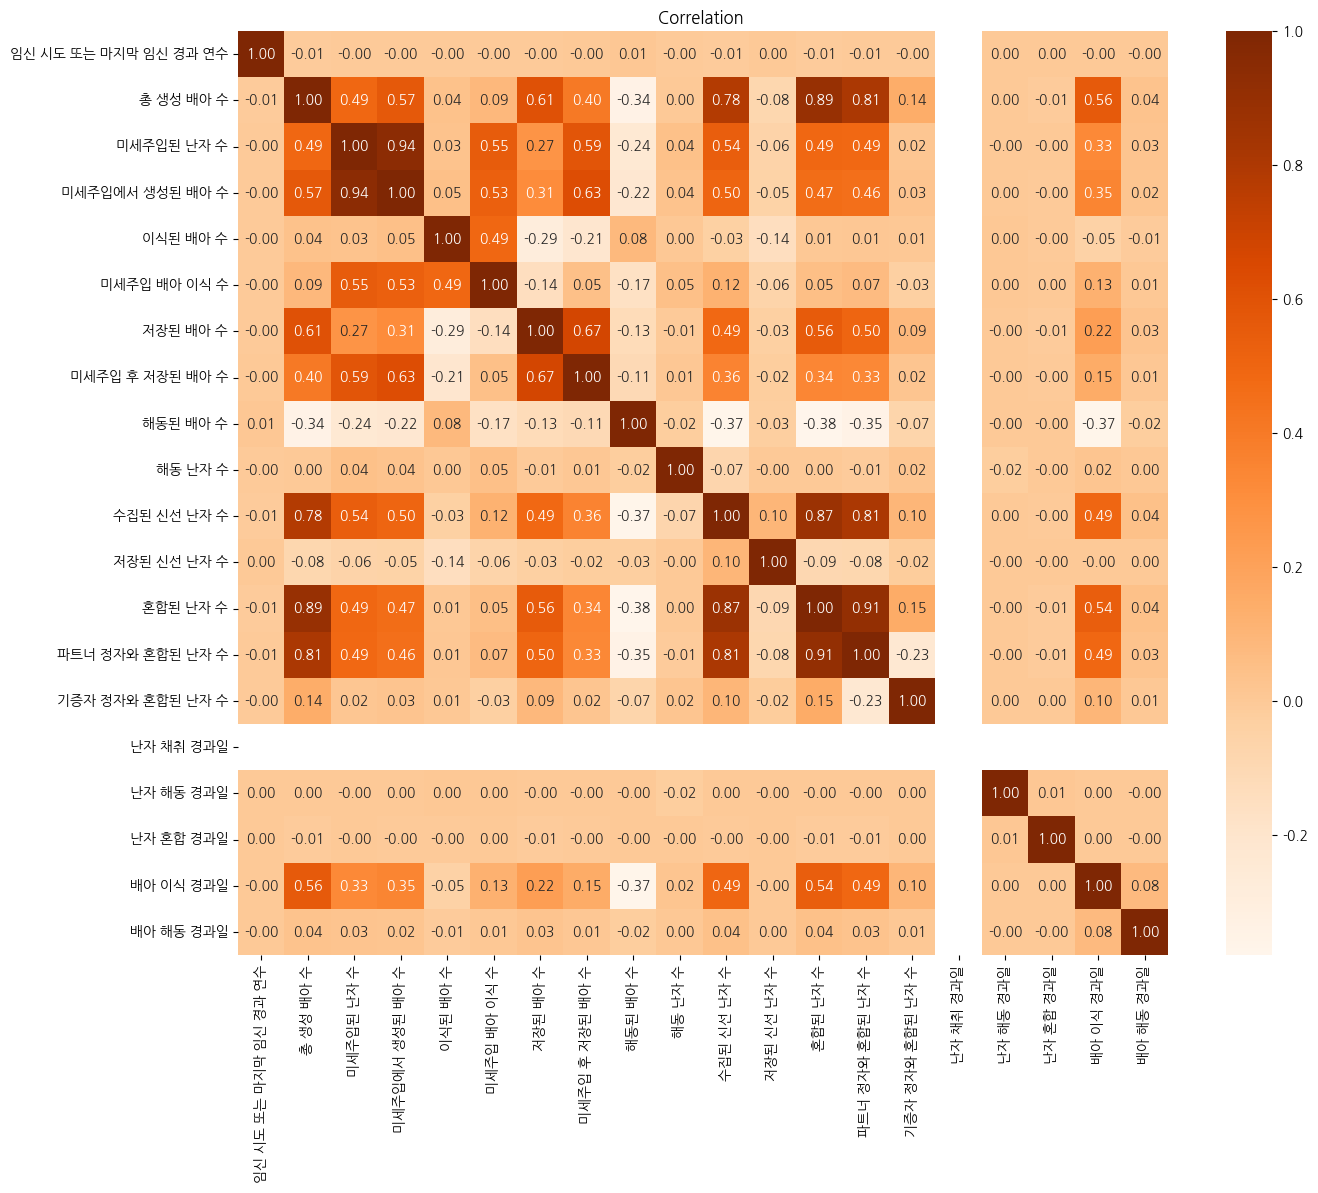

In [153]:
import seaborn as sns
corr=train_df[numeric_columns].corr()
fig = plt.figure(figsize=(15,12))
r = sns.heatmap(corr, cmap='Oranges', annot=True, fmt=".2f")
r.set_title("Correlation ")

### StandardScaler

In [105]:
# StandardScaler 객체 생성 및 Train 데이터에 fit
scaler = StandardScaler()
scaler.fit(train_df[numeric_columns])  # Train 데이터로 스케일러 학습

# Train과 Test 데이터 변환 (transform)
train_df[numeric_columns] = scaler.transform(train_df[numeric_columns])
test_df[numeric_columns] = scaler.transform(test_df[numeric_columns])

### train / test 칼럼 일치하는지 확인

In [106]:
# 1️⃣ Train에서 '임신 성공 여부' 제외한 컬럼 리스트 생성
train_columns = train_df.drop(columns=["임신 성공 여부"]).columns.tolist()
test_columns = test_df.columns.tolist()

# 2️⃣ 컬럼 순서 및 이름이 일치하는지 확인
if train_columns == test_columns:
    print("✅ Train과 Test의 컬럼 순서 및 이름이 일치합니다.")
else:
    print("⚠ Train과 Test의 컬럼 순서 또는 이름이 일치하지 않습니다. 일치 작업을 수행합니다.")

    # 3️⃣ Train에만 존재하는 컬럼 확인 (타겟 변수 제외)
    train_only_cols = set(train_columns) - set(test_columns)
    print("🔹 Train에만 있는 컬럼 (제외할 변수):", train_only_cols)

    # 4️⃣ Test에만 존재하는 컬럼 확인
    test_only_cols = set(test_columns) - set(train_columns)
    print("🔹 Test에만 있는 컬럼 (추가할 변수):", test_only_cols)

    # # 5️⃣ Train에 없는 Test 컬럼을 Train에 추가 (값은 0으로 초기화)
    # for col in test_only_cols:
    #     train_df[col] = 0

    # # 6️⃣ Test에 없는 Train 컬럼을 Test에 추가 (값은 0으로 초기화)
    # for col in train_only_cols:
    #     test_df[col] = 0

    # 7️⃣ Train과 Test 컬럼 순서 동일하게 정렬
    test_df = test_df[train_columns]  # '임신 성공 여부'를 제외한 Train의 순서로 정렬

    print("✅ 컬럼 일치 완료.")

# 최종 확인
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

✅ Train과 Test의 컬럼 순서 및 이름이 일치합니다.
Train shape: (256351, 74), Test shape: (90067, 73)


### 분산 0인 칼럼 삭제

In [107]:
train_df = train_df.drop(columns = ["불임 원인 - 여성 요인", "난자 채취 경과일"])
test_df = test_df.drop(columns = ["불임 원인 - 여성 요인", "난자 채취 경과일"])

In [108]:
dfSummary(train_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,시술 시기 코드[object],1. TRDQAZ2. TRCMWS3. TRYBLT4. TRVNRY5. TRJXFG6. TRZKPL7. TRXQMD,"38,969 (15.2%)38,090 (14.9%)36,713 (14.3%)36,173 (14.1%)36,031 (14.1%)35,544 (13.9%)34,831 (13.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACo0lEQVR4nO3bQUojUQBF0Z8mSDtJCAEX4yJ6sb2I7EYkNWjFSXrQIBrjzH+b4DkLqGRwqaKK/1an02lA4cf//gN8H2IjIzYyYiMjNjKrMcbtGONm4m+8nE6np4nX50qs9/v9r81ms5v1A8uyPK5Wq9+CY73ZbHb39/dP2+32+asvfjwefx4Oh93Dw8PNGENs39x6jDG22+3z3d3dn0m/cTvpulwZLwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxk1mP8Owo04+Kzrst1Wi/L8ng4HHZj0lGgZVkexxgvM67NdXEsnMzKIp7K7Dubuxqvpg5ejF14a9rgxdiFc7MHL8YuvPJRl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyExbV1lWcW7qusqyirdsEMhYV5GZeWdzV+OdaesqyyrOTVlXWVZxycx1lWUV7/ioS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERmbK4MXYhUumDV6MXTjnWDgZgxcyXhDIeIySsa4iY11FxrqKjBcEMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MtZVZKyryDgWTsa6iow7GxmDFzIGL2QMXsj4qEtGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbG4IWMwQsZx8LJGLyQ8YJAZtZj1COUD6asqyyruOTL11WWVXxm1rrKsooPvCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGR+fJ1lWUVn5myrrKs4hLHwslYV5FxZyNj8ELG4IWMwQsZH3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MdRUZ6yoyNghkrKvIeEEgIzYyYiMjNjJ/AVBveRWtjjpOAAAAAElFTkSuQmCC"">",0(0.0%)
2,시술 당시 나이[int64],1. 12. 23. 34. 45. 56. 6,"102,805 (40.1%)57,780 (22.5%)39,247 (15.3%)37,348 (14.6%)12,253 (4.8%)6,918 (2.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACm0lEQVR4nO3bUWoTUQCG0RsJRV8SQqGL6SJcrIvIbkrpPKj4Eh9EidW2L5lvhuacFdzAxw0zzL85nU4DCh+WPgDXQ2xkxEZGbGQ2Y4xPY4ybpQ+ygB+n0+nb0oe4Jtvb29vPu93usPRBatM0PW42my+C62x3u93h/v7+236//770YSpPT08fj8fj4eHh4WaMIbbIdowx9vv997u7u69LHyb2aekDXBsPCGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGS2Y/z65Gbpg5Su7feuxXaapsfj8XgYV/bJzTRNj2OMH0uf45r4LJzMxkiZytpuNrfNO7aqwYsRyvu2msGLEcr7t7bBy1U9EV8bL3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MatZVazgD81rVusri6X2zQSBjXUWmuNncVowxgnWVxRS/zbquspjiXLGuWvwpl3XwUpeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MjMuq6ymOLc7Osqiyl+s0EgY11FZu6bza3GH7OuqyyrODfbusqyiufmXldZVvGHl7pkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkZhu8GLvw3KyDF2MXzvksnIzBCxkPCGTe+hv1N8jFvLquso7ikl5cV1lHcWlvrauso7gYDwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkXlxXWUdxaa+uq6yjuCSfhZOxriLzv5vNbcYs/hm8GLkwl78GL0YuzOl/gxcjF2bhpS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZH5a11lUcWc/llXWVQxFxsEMtZVZDwgkBEbGbGR+QlvGEOmIUukPQAAAABJRU5ErkJggg=="">",0(0.0%)
3,임신 시도 또는 마지막 임신 경과 연수[float64],Mean (sd) : -0.0 (1.0)min < med < max:-13.7 < -0.0 < 15.8IQR (CV) : 0.0 (-0.0),22 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB00lEQVR4nO3XvU4CURRF4XOGHyHBuQESShpLEx+A3taHtbWn8B3sKSACEUEml2tvEJ0JEbasr9+Zc5PVjKeUDDh32akPAH6jfuoDzpW7t82sWXG+TSmtj3nPpSPUPdy93e/3H/I871bZL5fLV3d/JNbjIdT9mnmed0ej0TqEsCkzXCwWrfF43J3NZk0zI9QjIdQDQgibwWDwXmHaPvoxF46fKUggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEion/qAQ9y9bWbNivPMzHYVt/lut2tU3FqMsWFmubtXmW9TSuuq3/6vfgzV3VtmdvUHt3zV6vV69yGETtlhjLGxWq1uOp3OS5ZlRdl9URStGOPtdDp9LrudTCbXRVHcDYfDWq1W25Tdz+fzN3d/MrPSW3EfKaVv3/wJ4xhQf0ibN0cAAAAASUVORK5CYII="">",0(0.0%)
4,시술 유형[object],1. IVF2. DI,"250,060 (97.5%)6,291 (2.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOElEQVR4nO3bMYqDQBiG4X8WCZtmBhE8jIfYw+4h5jYiTrEJaWaLIKzGLvoNzL5PZ/cXL0KCn8s5G6

# Modeling

In [109]:
categorical_columns = [
    "시술 시기 코드", "시술 유형", "배란 자극 여부", "단일 배아 이식 여부", "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부", "남성 주 불임 원인", "남성 부 불임 원인", "여성 주 불임 원인", "여성 부 불임 원인",
    "부부 주 불임 원인", "부부 부 불임 원인", "불명확 불임 원인", "불임 원인 - 난관 질환", "불임 원인 - 남성 요인",
    "불임 원인 - 배란 장애", "불임 원인 - 자궁경부 문제", "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도", "불임 원인 - 정자 면역학적 요인", "불임 원인 - 정자 운동성", "불임 원인 - 정자 형태",
    '현재 시술용', '난자 저장용', '배아 저장용', '기증용', '연구용',    # 배아 생성 주요 이유
    "난자 출처", "정자 출처", "동결 배아 사용 여부", "신선 배아 사용 여부", "기증 배아 사용 여부", 
    "대리모 여부", "PGD 시술 여부", "PGS 시술 여부",
    "정자 기증자 나이_알 수 없음", "난자 기증자 나이_알 수 없음", "메인 시술", "보조 시술"
]

In [110]:
for col in categorical_columns:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

In [111]:
X = train_df.drop(columns=['임신 성공 여부'])
y = train_df['임신 성공 여부']

In [131]:
# 1️⃣ Train/Validation 데이터 분리
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, train_size=0.7, random_state=42, stratify=y
)

# 2️⃣ 범주형 데이터 처리 (CatBoost에서 인식할 수 있도록)
for col in categorical_columns:
    X_train[col] = X_train[col].astype(str)
    X_validation[col] = X_validation[col].astype(str)
    test_df[col] = test_df[col].astype(str)

# 3️⃣ CatBoost Pool 생성 (범주형 변수 명시)
train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
eval_pool = Pool(X_validation, y_validation, cat_features=categorical_columns)

# 4️⃣ Random Sampler 설정
sampler = TPESampler(seed=10)

# 5️⃣ Objective 함수 정의
def objective(trial):
    # 5-1) Hyperparameter 탐색 공간 정의
    param = {
        "random_state": trial.suggest_int('random_state', 0, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.131, 0.136),
        'depth': 5,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'verbose': False
    }
    
    # 5-2) CatBoost 모델 생성
    model = CatBoostClassifier(**param, cat_features=categorical_columns)

    # 5-3) 10-Fold Cross Validation 설정
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    roc_auc_list = []

    # 5-4) 10-Fold Cross Validation 실행
    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # 5-5) CatBoost의 Pool 활용 (범주형 변수 포함)
        train_fold_pool = Pool(X_tr, y_tr, cat_features=categorical_columns)
        valid_fold_pool = Pool(X_val, y_val, cat_features=categorical_columns)

        # 5-6) 모델 학습
        model.fit(train_fold_pool, eval_set=valid_fold_pool, early_stopping_rounds=35, verbose=False)

        # 5-7) ROC-AUC Score 계산
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        roc_auc_list.append(roc_auc_score(y_val, y_pred_prob))
    
    return np.mean(roc_auc_list)

# 6️⃣ Optuna Study 생성 및 최적화 실행
optuna_cbrm = optuna.create_study(direction='maximize', sampler=sampler)
optuna_cbrm.optimize(objective, n_trials=30)

[I 2025-02-03 16:18:02,309] A new study created in memory with name: no-name-c25b4656-cbc0-4609-8255-317ff7855c8c
[I 2025-02-03 16:19:28,565] Trial 0 finished with value: 0.7404894452956599 and parameters: {'learning_rate': 0.13485660321633375}. Best is trial 0 with value: 0.7404894452956599.
[I 2025-02-03 16:21:02,755] Trial 1 finished with value: 0.7404563489280187 and parameters: {'learning_rate': 0.131103759746797}. Best is trial 0 with value: 0.7404894452956599.
[I 2025-02-03 16:22:22,867] Trial 2 finished with value: 0.7403779970205666 and parameters: {'learning_rate': 0.1341682411746314}. Best is trial 0 with value: 0.7404894452956599.
[I 2025-02-03 16:23:50,525] Trial 3 finished with value: 0.7403895479416884 and parameters: {'learning_rate': 0.13474401941269307}. Best is trial 0 with value: 0.7404894452956599.
[I 2025-02-03 16:25:14,486] Trial 4 finished with value: 0.7404616009187726 and parameters: {'learning_rate': 0.13349253506151296}. Best is trial 0 with value: 0.7404894

KeyboardInterrupt: 

In [126]:
# 7️⃣ 최적 파라미터 출력
cbrm_trial = optuna_cbrm.best_trial
cbrm_trial_params = cbrm_trial.params
print(f'Best Trial: score {cbrm_trial.value},\nparams {cbrm_trial_params}')

Best Trial: score 0.7407158123965654,
params {'learning_rate': 0.13287428923025357}


In [127]:
final_model = CatBoostClassifier(**cbrm_trial_params, cat_features=categorical_columns)
final_model.fit(train_pool, eval_set=eval_pool, use_best_model=True, verbose=200)

0:	learn: 0.6151796	test: 0.6155116	best: 0.6155116 (0)	total: 81.8ms	remaining: 1m 21s
200:	learn: 0.4806172	test: 0.4899228	best: 0.4898026 (116)	total: 7.78s	remaining: 30.9s
400:	learn: 0.4758549	test: 0.4902007	best: 0.4898026 (116)	total: 15.8s	remaining: 23.5s
600:	learn: 0.4721827	test: 0.4907989	best: 0.4898026 (116)	total: 23.5s	remaining: 15.6s
800:	learn: 0.4687238	test: 0.4914822	best: 0.4898026 (116)	total: 31.4s	remaining: 7.81s
999:	learn: 0.4654933	test: 0.4920372	best: 0.4898026 (116)	total: 39.5s	remaining: 0us

bestTest = 0.4898026468
bestIteration = 116

Shrink model to first 117 iterations.


In [130]:
from sklearn.metrics import classification_report, roc_auc_score

# 모델 예측
pred = final_model.predict(eval_pool)
pred_proba = final_model.predict_proba(eval_pool)[:, 1]  # 양성 클래스 확률

# 분류 리포트 출력
print(classification_report(y_validation, pred, digits=5))

# ✅ ROC-AUC Score 계산
roc_auc = roc_auc_score(y_validation, pred_proba)
print(f"ROC-AUC Score: {roc_auc:.8f}")

              precision    recall  f1-score   support

           0    0.75636   0.96893   0.84955     57037
           1    0.53842   0.10403   0.17437     19869

    accuracy                        0.74548     76906
   macro avg    0.64739   0.53648   0.51196     76906
weighted avg    0.70006   0.74548   0.67512     76906

ROC-AUC Score: 0.73656016


✅ Test 데이터에 대한 예측 완료.


# Submission

In [ ]:
# 9️⃣ Test 데이터 예측 수행 (CatBoost의 Pool 활용)
test_pool = Pool(test_df, cat_features=categorical_columns)
y_predict = final_model.predict_proba(test_pool)[:, 1]

# 결과 확인
print("✅ Test 데이터에 대한 예측 완료.")

In [120]:
sample_submission = pd.read_csv('./submit/sample_submission.csv')
sample_submission['probability'].value_counts()

probability
0.0    90067
Name: count, dtype: int64

<Axes: >

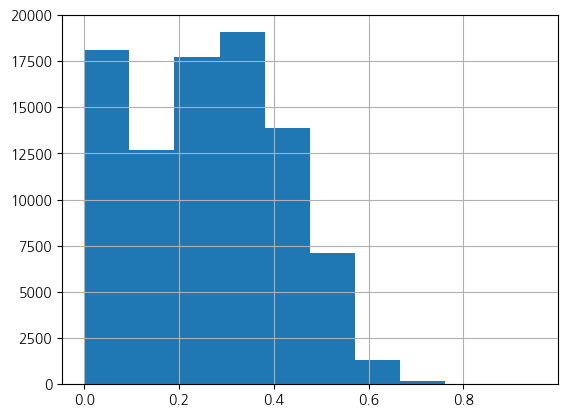

In [121]:
sample_submission['probability'] = y_predict
sample_submission['probability'].hist()

In [124]:
sample_submission.to_csv('./submit/catboost_optuna_submit.csv', index=False)